In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
from tqdm import trange
import pandas as pd
pd.set_option('expand_frame_repr', False)
from matplotlib.ticker import FormatStrFormatter  
sns.set(font_scale=2)
import sys
import json
import os
import re
from scipy.stats import pearsonr
import pickle

## Util

In [2]:
dataset_name = ['ETTm1','ETTm2','ETTh1','ETTh2','Exchange','Weather', 'Traffic', 'Electricity','ILI', 'Solar Hour', 'Solar 10min', 'River Flow', 'Sunspot']
datasets = ['ettm1','ettm2','etth1','etth2','exchange_ltsf','weather_ltsf','illness_ltsf','sunspot', 'solar_hour', 'solar_10min','river_flow']
def replace_dataset_name(df):
    df['dataset'] = df['dataset'].replace('ettm1', 'ETTm1', regex=True) 
    df['dataset'] = df['dataset'].replace('ettm2', 'ETTm2', regex=True) 
    df['dataset'] = df['dataset'].replace('etth1', 'ETTh1', regex=True) 
    df['dataset'] = df['dataset'].replace('etth2', 'ETTh2', regex=True) 
    df['dataset'] = df['dataset'].replace('exchange_ltsf', 'Exchange', regex=True) 
    df['dataset'] = df['dataset'].replace('weather_ltsf', 'Weather', regex=True) 
    df['dataset'] = df['dataset'].replace('traffic_ltsf', 'Traffic', regex=True) 
    df['dataset'] = df['dataset'].replace('electricity_ltsf', 'Electricity', regex=True) 
    df['dataset'] = df['dataset'].replace('illness_ltsf', 'ILI', regex=True) 
    df['dataset'] = df['dataset'].replace('solar_hour', 'Solar Hour', regex=True) 
    df['dataset'] = df['dataset'].replace('solar_10min', 'Solar 10min', regex=True) 
    df['dataset'] = df['dataset'].replace('river_flow', 'River Flow', regex=True) 
    df['dataset'] = df['dataset'].replace('sunspot', 'Sunspot', regex=True) 
    return df

def sort_order(cat_res, sort_order_dict=None, inf_sort_order=False):
    # cat_res = cat_res.loc[cat_res['Infer hor.'] != '24']
    
    # inf_sort_order = ['48', '60', '96', '192', '336', '720', '1024']
    if inf_sort_order:
        inf_sort_order = ['24', '48', '96', '192','336', '720', '1024']
        cat_res['Infer hor.'] = pd.Categorical(cat_res['Infer hor.'], categories=inf_sort_order, ordered=True)
        cat_res = cat_res.sort_values(by='Infer hor.')
    
    if sort_order_dict is not None:
        for key, value in sort_order_dict.items():
            cat_res[key] = pd.Categorical(cat_res[key], categories=value, ordered=True)
            cat_res = cat_res.sort_values(by=key)
    
    return cat_res

def filed_filter(df, fileds_dict, eq=True):
    for key, values in fileds_dict.items():
        if eq:
            df = df[df[key].isin(values)]
        else:
            df = df[~df[key].isin(values)]
                
    return df

def add_spec_setting(res_dict, prefix=''):
    datasets = []
    infer_hor = []
    train_hor = []
    val_hor = []
    ND = []
    NRMSE = []
    seed = []
    for dataset in ['ETTm1','ETTm2','ETTh1','ETTh2','Exchange','Weather', 'Electricity','Traffic', 'Solar Hour', 'Solar 10min', 'River Flow', 'Sunspot']:
        for hor in ['96', '192', '336', '720']:
            try: 
                ND.append(res_dict[(res_dict['val_len']==hor) & (res_dict['Infer hor.']==hor) & (res_dict['Train hor.']==hor) & (res_dict['dataset']==dataset)]['ND'].values[0])
                NRMSE.append(res_dict[(res_dict['val_len']==hor) & (res_dict['Infer hor.']==hor) & (res_dict['Train hor.']==hor) & (res_dict['dataset']==dataset)]['NRMSE'].values[0])
                datasets.append(dataset)
                infer_hor.append(hor)
                train_hor.append(prefix+'spec')
                val_hor.append(prefix+'spec')
                seed.append(0)
            except:
                continue
            
    res_dict = {"dataset": datasets, "Infer hor.": infer_hor, "Train hor.": train_hor, "val_len": val_hor, "ND": ND , "NRMSE": NRMSE, "seeds": seed,}
    return pd.DataFrame(res_dict)

def plot_multi_marked_line(res,  x,  y, hue=None, style=None, title=None, datasets=['ETTh1'],save_name=None,line_styles=False, 
                           line_style_list=None,errorbar=None, palette=None, data_char=None, axvline=None,axhline=None, axhline_label=None,
                           hight=5, width=6, x_min=None, x_max=None, all_in_one=False, font_scale=1.5):
    sns.set(font_scale=font_scale)
    sub_num = len(datasets)
    if palette:
        sns.set_palette(palette)
    if sub_num > 1 and not all_in_one:
        plt.figure()
        total_len = sub_num * width
        fig, ax = plt.subplots(1, sub_num,figsize=(total_len, hight))  
        legend = False
        for i in range(sub_num):
            if line_style_list is not None:
                local_line_style = line_style_list[i]
            else:
                local_line_style = line_styles
                
            if datasets[i] == 'ETT':
                sub_res = res[(res['dataset']=='ETTm1') | (res['dataset']=='ETTm2') | (res['dataset']=='ETTh1') | (res['dataset']=='ETTh2')]
            else:
                sub_res = res[res['dataset']==datasets[i]]
                
            if i == (sub_num-1):
                legend = True
            sns.lineplot(
                data=sub_res, legend=legend,
                x=x, y=y, hue=hue, style=style, ax=ax[i], errorbar=errorbar,
                markers=True, dashes=local_line_style, linewidth=2,markersize=10
            )
            if axvline is not None:
                ax[i].axvline(x=axvline, color='r', linestyle='--', linewidth=2,markersize=10) 
            ax[i].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            
            if data_char is not None:
                season = data_char[datasets[i]]['Seasonality']
                trend = data_char[datasets[i]]['Trend']
                data_char_str = f'\nFs:{season} Ft:{trend}'
            else:
                data_char_str = ''
            ax[i].set_title(f'{datasets[i]}{data_char_str}')  
            ax[i].tick_params(axis='y', labelsize=15)    
            ax[i].tick_params(axis='x', labelsize=16)    
            if i > 0:
                ax[i].set_ylabel('')
                
        if title is not None:
            fig.suptitle(title)
    else:
        plt.figure(figsize=(width, hight))
        if datasets[0] == 'ETT':
            sub_res = res[(res['dataset']=='ETTm1') | (res['dataset']=='ETTm2') | (res['dataset']=='ETTh1') | (res['dataset']=='ETTh2')]
        else:
            # sub_res = res[res['dataset']==datasets[0]]
            sub_res = res[res['dataset'].isin(datasets)]
        sns.lineplot(
            data=sub_res,
            x=x, 
            y=y, 
            hue=hue, style=style, errorbar=None,
            markers=True, dashes=line_styles, linewidth=2, markersize=10
        )
        if axvline is not None:
            plt.axvline(x=axvline, color='r', linestyle='--', linewidth=2,markersize=10) 
            
        if axhline is not None:
            plt.axhline(y=axhline, color='gray', linestyle='--', linewidth=2, label=axhline_label)
        
        if x_min is not None:
            plt.xlim(x_min, x_max)
            
        if title is not None:
            plt.title(title)
    
    # plt.legend(title=hue, loc='upper left', bbox_to_anchor=(1, 1))  
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1),title=hue)  
    plt.tight_layout() 
    if save_name is not None:
        plt.savefig(f'fig/{save_name}.svg', format='svg') 

## Load data

In [3]:
def load_result(root_dir, verbose=True, models=['PatchTST'], train_pred_len_list=['24','36','48','60','96','192','336','720'], train_context_list=['36','96'], datasets=None):
    NRMSE = []
    ND = []
    CRPS = []
    train_pred_len_lists = []
    dataset_list = []
    seeds = []
    train_ctx = []
    model_list = []
    if datasets is None:
        datasets = ['ettm1','ettm2','etth1','etth2','exchange_ltsf','weather_ltsf','electricity_ltsf','traffic_ltsf','illness_ltsf']

    seed=0
    
    for dataset in datasets:
        for model in models:
            for train_pred_len in train_pred_len_list:
                for train_context in train_context_list:
                    csv_file = root_dir + f"{dataset}_{train_context}_{train_pred_len}_{model}_{seed}/test/metrics.csv"
                    try:
                        data = pd.read_csv(csv_file)
                    except:
                        if verbose:
                            print("cannot find ", csv_file) 
                        continue
                    
                    for idx in range(len(data)):
                        NRMSE.append(data['test_NRMSE'][idx])
                        ND.append(data['test_ND'][idx])
                        CRPS.append(data['test_CRPS'][idx])

                        dataset_list.append(dataset)
                        model_str = model
                        train_pred_len_lists.append(train_pred_len)
                        train_ctx.append(train_context)
                        model_list.append(model_str)
                        seeds.append(seed)

    res_dict = {"dataset": dataset_list, "pred hor.": train_pred_len_lists, "ND":ND , "NRMSE": NRMSE, 'CRPS':CRPS, "seeds": seeds,
                "model": model_list,'train_ctx': train_ctx}

    return pd.DataFrame(res_dict)


# ReVIN

## long

In [4]:
# PatchTST

datasets=None
root_dir = "/home/v-zhangjiaw/Blob_WestJP/v-jiawezhang/log/abl_revin/norm_false/logs/"
norm_false_res = load_result(root_dir=root_dir, verbose=False, models=['PatchTST'], datasets=datasets) 
norm_false_res['scaling'] = 'false'
norm_false_res['revin'] = 'false'

root_dir = "/home/v-zhangjiaw/Blob_WestJP/v-jiawezhang/log/abl_revin/norm_true/logs/"
norm_true_res = load_result(root_dir=root_dir, verbose=False, models=['PatchTST'], datasets=datasets) 
norm_true_res['scaling'] = 'false'
norm_true_res['revin'] = 'true'

root_dir = "/home/v-zhangjiaw/Blob_WestJP/v-jiawezhang/log/abl_revin/norm_temp/logs/"
norm_temp_res = load_result(root_dir=root_dir, verbose=False, models=['PatchTST'], datasets=datasets) 
norm_temp_res['scaling'] = 'true'
norm_temp_res['revin'] = 'false'

patchtst_res= pd.concat([norm_false_res, norm_true_res, norm_temp_res], ignore_index=True)
patchtst_res['scaler'] = 'standard'

In [5]:
def get_df_results(root_path, models,datasets=None,verbose=False):
    combined_df = pd.DataFrame()
    if datasets is None:
        datasets = ['etth1','exchange_ltsf','weather_ltsf','traffic_ltsf','electricity_ltsf','illness_ltsf']
    for scaler in ['identity', 'standard']:
        for revin in ['true', 'false']:
            for scaling in ['false', 'true']:
                norm_res = load_result(root_dir = f"{root_path}{scaler}_revin_{revin}_scaling_{scaling}/logs/", verbose=verbose, models=models, datasets=datasets)
                norm_res['scaler'] = scaler
                norm_res['revin'] = revin
                norm_res['scaling'] = scaling
                combined_df = pd.concat([combined_df, norm_res], ignore_index=True)
    return combined_df

In [6]:
gru_nvp_res = get_df_results('/home/v-zhangjiaw/Blob_WestJP/v-jiawezhang/log/abl_norm/', ['GRU_NVP'])
csdi_res = get_df_results('/home/v-zhangjiaw/Blob_EastUS/v-jiawezhang/log/abl_norm/', ['CSDI'])
timegrad_res = get_df_results('/home/v-zhangjiaw/Blob_EastUS/v-jiawezhang/log/abl_norm/', ['TimeGrad'])
gru_res = get_df_results('/home/v-zhangjiaw/Blob_WestJP/v-jiawezhang/log/abl_norm/', ['GRUForecaster'])
patchtst_ili_res = get_df_results('/home/v-zhangjiaw/Blob_EastUS/v-jiawezhang/log/abl_norm/', ['PatchTST'],datasets=['illness_ltsf'])
gru_nvp_ili_res = get_df_results('/home/v-zhangjiaw/Blob_EastUS/v-jiawezhang/log/abl_norm/', ['GRU_NVP'],datasets=['illness_ltsf'])

combined_df = pd.concat([patchtst_res, patchtst_ili_res, gru_nvp_res, gru_nvp_ili_res, csdi_res, timegrad_res, gru_res], ignore_index=True)

In [7]:
def reformat(res_dict):
    datasets = []
    pred_hor = []
    norm = []
    ND = []
    CRPS = []
    seed = []
    global_norm = []
    model = []
    for index, row in res_dict.iterrows():
        if row['revin'] == 'true' and row['scaling'] == 'false':
            norm.append('ReVIN')
        elif row['revin'] == 'false' and row['scaling'] == 'true':
            norm.append('Scaling')
        elif row['revin'] == 'false' and row['scaling'] == 'false':
            norm.append('None')
        else:
            continue
        
        datasets.append(row['dataset'])
        pred_hor.append(row['pred hor.'])
        ND.append(row['ND'])
        global_norm.append(row['scaler'])
        CRPS.append(row['CRPS'])
        model.append(row['model'])
        
            
    res_dict = {'model': model, "dataset": datasets, "gobal norm": global_norm, "pred hor.": pred_hor, "CRPS": CRPS, "ND": ND , "norm": norm}
    return pd.DataFrame(res_dict)

In [8]:
norm_res = reformat(combined_df)
norm_res = replace_dataset_name(norm_res)

sort_order_dict = {'pred hor.': ['24','36','48','60','96','192','336','720'], 'model': ['PatchTST', 'CSDI','TimeGrad', 'GRU_NVP','GRUForecaster'], 'norm': ['ReVIN', 'Scaling','None']}
sort_norm_res = sort_order(norm_res, sort_order_dict=sort_order_dict)

In [9]:
# sort_norm_res['CRPS/ND'] = sort_norm_res.apply(lambda x: f"{x['CRPS']:.3f}/{x['ND']:.3f}", axis=1)
sort_norm_res['ND'] = sort_norm_res.apply(lambda x: f"{x['ND']:.4f}", axis=1)
sort_norm_res['CRPS'] = sort_norm_res.apply(lambda x: f"{x['CRPS']:.4f}", axis=1)

sort_norm_res = sort_norm_res[sort_norm_res["gobal norm"]=='standard']

In [10]:
# Create a pivot table
pivot_table = pd.pivot_table(
    sort_norm_res,
    values=['CRPS'],
    index=['dataset', 'pred hor.'],
    columns=['model', 'norm'],
    aggfunc=lambda x: x.iloc[0],
    observed=False
)

def to_markdown(pivot_table):
    pivot_table.columns = ['_'.join(col).strip() for col in pivot_table.columns.values]
    pivot_table = pivot_table.reset_index()
    pivot_table_formatted_md = pivot_table.to_markdown()
    return pivot_table_formatted_md

In [11]:
import re

def mark_best_value(data):
    # 切分数据到行
    lines = data.strip().split('\n')

    # 准备新的表格内容
    new_lines = []
    count = 0
    for line in lines:
        if 'dataset' in line or "tabular" in line or 'rule' in line or 'multicolumn' in line or 'norm' in line:
            new_lines.append(line)  # 添加标题行
            continue
        
        if 'cline' in line:
            continue
        
        pattern = r"\b\d+\.\d{2,4}\b|NaN"
        values = re.findall(pattern, line)

        def mark_values(value_list, marker='bold'):
            
            numeric_values = []
            for v in value_list:
                if v != '-' and v != 'NaN':
                    numeric_values.append(float(v.split('_')[0]))
                else:
                    numeric_values.append(1000)

            # 排序获取索引
            sorted_indices = sorted(range(len(numeric_values)), key=lambda k: numeric_values[k], reverse=False)
            
            # 处理相同最小值的情况
            min_val = numeric_values[sorted_indices[0]]
            min_count = numeric_values.count(min_val)
            
            # 标记最小值
            for i in range(min_count):
                if marker=='bold':
                    value_list[sorted_indices[i]] = r'\bm{' + value_list[sorted_indices[i]] + '}'
                else:
                    value_list[sorted_indices[i]] = r'\underline{' + value_list[sorted_indices[i]] + '}'

            return value_list

        marked_values = [None]*len(values)
        for i in range(0, len(values), 3):
            marked_values[i:i+3] = mark_values(values[i:i+3],marker='bold')
            
        numeric_values = [float(re.search(r'(\d+\.\d+)', v).group(1)) for v in marked_values if re.search(r'(\d+\.\d+)', v)]
        min_value = min(numeric_values)
        
        def add_underline(value, min_value):
            matched_value = re.search(r'(\d+\.\d+)', value)
            if matched_value:
                if float(min_value) == float(matched_value.group(1)):
                    value = r'\underline{' + value + '}'
            return value
        
        updated_values = [add_underline(v, min_value) for v in marked_values]
        
        # 构造新行
        new_line_parts = line.split('&')
        new_line_parts[2:] = [' $' + v + '$' for v in updated_values]
        new_line = ' & '.join(new_line_parts) + ' \\\\ '
        
        new_line = new_line.replace('_{0.', '_{.')
        new_line = new_line.replace('\multirow[t]', '\multirow[c]')
        new_line = new_line.replace('$NaN$', '-')
        new_line = new_line.replace('$\\bm{NaN}$', '-')
        new_lines.append(new_line)
        
        if '&  720  &' in new_line or '&  60  &' in new_line:
            new_lines.append('\midrule')

    # 将新的行合并成最终的表格
    final_table = '\n'.join(new_lines)
    print(final_table)

In [ ]:
# print(pivot_table_formatted_md)
pivot_table

In [24]:
latex_code = pivot_table.to_latex(multicolumn=True, multirow=True)

In [ ]:
mark_best_value(latex_code)

## Plot scatter

In [79]:
def get_gap_dict(data):
    data_char = pd.read_csv("./exp_res/data_char.csv",index_col='Data Characteristic')
    custom_palette = {
        "NAR": (0.2980392156862745, 0.4470588235294118, 0.6901960784313725),  # 蓝色
        "AR": (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),  # 橙色
    }
    
    datasets = []
    horizons = []
    models = []
    score_gap_list = []
    dec_scheme = []
    revin_score = []
    seasonality = []
    trend = []
    for model in ['PatchTST', 'TimeGrad','GRU_NVP', 'GRUForecaster']:
        for idx in pivot_table.index:
            if pivot_table['CRPS']['PatchTST']['ReVIN'][idx] == 'NaN':
                continue
            score_gap = float(pivot_table['CRPS'][model]['ReVIN'][idx]) - float(pivot_table['CRPS'][model]['None'][idx])
            datasets.append(idx[0])
            horizons.append(idx[1])
            models.append(model)
            seasonality.append(data_char.loc['Seasonality'][idx[0]+'-L'])
            trend.append(data_char.loc['Trend'][idx[0]+'-L'])
            revin_score.append(float(pivot_table['CRPS']['PatchTST']['ReVIN'][idx]))
            if model in ['TimeGrad','GRU_NVP', 'GRUForecaster']:
                dec_scheme.append('AR')
            else:
                dec_scheme.append('NAR')
            score_gap_list.append(score_gap)
            
    score_gap_dict = {'Dataset': datasets, 'Gap': score_gap_list, 'Horizon': horizons, 'Model': models, 'Type': dec_scheme, 'ReVIN': revin_score, 'Seasonality': seasonality, 'Trend': trend}

    gap_pd = pd.DataFrame(score_gap_dict)
    return gap_pd
    
def plot_norm_scatter(gap_dict, x, y, hue, style, size, hight=5, width=6):
    plt.figure(figsize=(width, hight))
    g = sns.scatterplot(data=gap_dict, x=x, y=y, hue=hue, style=style, size=size, palette="coolwarm", sizes=(40, 1000))
    g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    plt.tight_layout() 
    plt.show()


In [67]:
gap_dict = get_gap_dict(pivot_table)

In [68]:
# sort_order_dict = {'pred hor.': ['24','36','48','60','96','192','336','720'], 'model': ['PatchTST', 'CSDI','TimeGrad', 'GRU_NVP','GRUForecaster'], 'norm': ['ReVIN', 'Scaling','None']}
sort_order_dict = {'Horizon': ['96','192','336','720'], 'Model': ['PatchTST', 'CSDI','TimeGrad', 'GRU_NVP','GRUForecaster']}
sort_norm_res = sort_order(gap_dict, sort_order_dict=sort_order_dict)

In [77]:
sort_norm_res

,Dataset,Gap,Horizon,Model,Type,ReVIN,Seasonality,Trend
0,ETTh1,-0.0235,96,PatchTST,NAR,0.3212,0.4772,0.7728
9,Exchange,-0.0068,192,PatchTST,NAR,0.0336,0.1349,0.9978
21,Weather,-0.0278,192,PatchTST,NAR,0.0858,0.2657,0.9612
17,Traffic,-0.0004,192,PatchTST,NAR,0.2479,0.6798,0.1632
6,Electricity,-0.0005,336,PatchTST,NAR,0.1001,0.8344,0.6476
...,...,...,...,...,...,...,...,...
90,Traffic,0.0530,336,GRUForecaster,AR,0.2492,0.6798,0.1632
74,ETTh1,-0.0958,336,GRUForecaster,AR,0.3737,0.4772,0.7728
79,Electricity,0.1773,720,GRUForecaster,AR,0.1160,0.8344,0.6476
77,Electricity,0.1082,192,GRUForecaster,AR,0.0912,0.8344,0.6476


In [83]:
grouped_df

,Model,Dataset,Horizon,Gap,ReVIN
0,PatchTST,ETTh1,96,-0.0235,0.3212
1,PatchTST,ETTh1,192,-0.0223,0.3562
2,PatchTST,ETTh1,336,-0.0362,0.3737
3,PatchTST,ETTh1,720,-0.0739,0.3909
4,PatchTST,Electricity,96,0.0009,0.0857
...,...,...,...,...,...
115,GRUForecaster,Traffic,720,0.1231,0.2572
116,GRUForecaster,Weather,96,-0.3592,0.0837
117,GRUForecaster,Weather,192,-0.3348,0.0858
118,GRUForecaster,Weather,336,-0.3404,0.0903


/tmp/ipykernel_10409/373040289.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = sort_norm_res.groupby(['Model', 'Dataset']).agg({'Gap': 'mean', 'ReVIN': 'mean', 'Seasonality': 'mean', 'Trend': 'mean'}).reset_index()


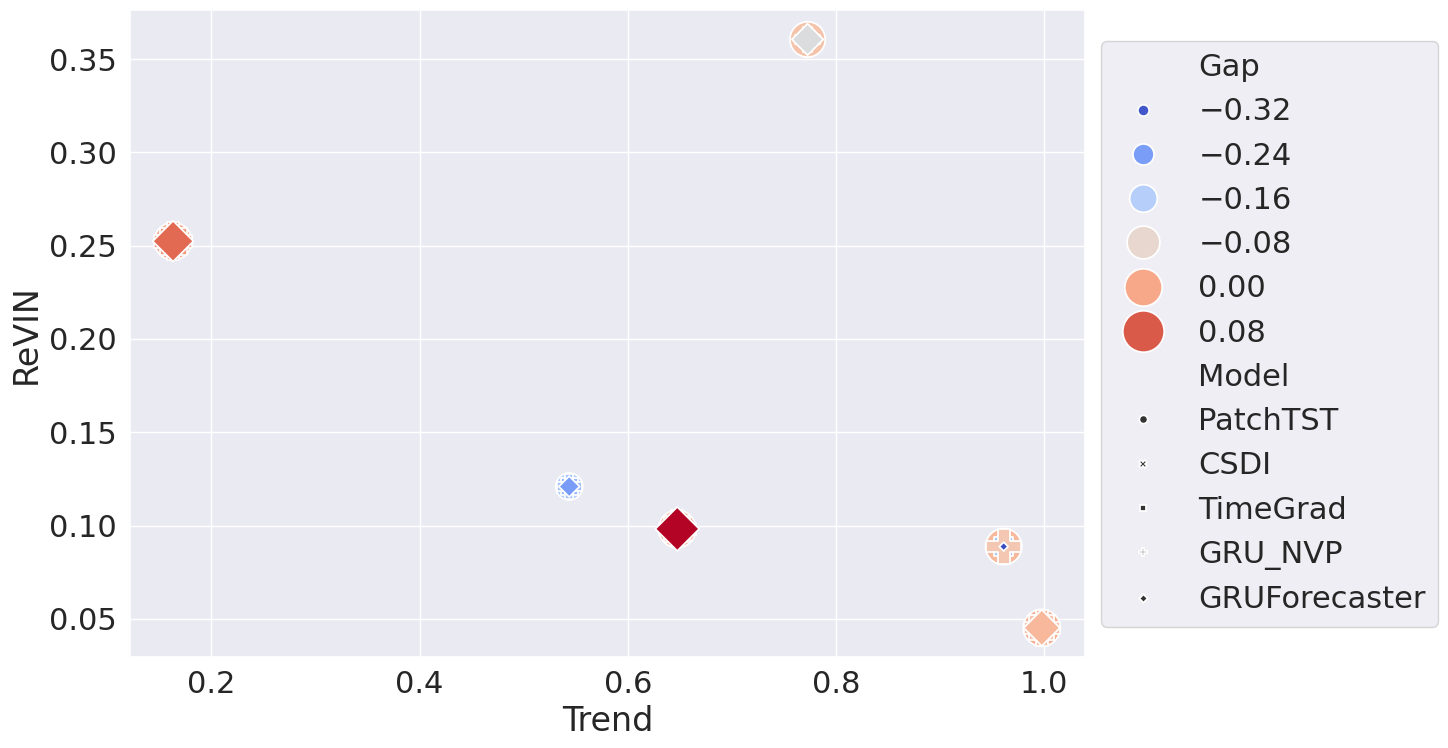

In [85]:
# grouped_df = sort_norm_res.groupby('Dataset')[].mean().reset_index()
grouped_df = sort_norm_res.groupby(['Model', 'Dataset']).agg({'Gap': 'mean', 'ReVIN': 'mean', 'Seasonality': 'mean', 'Trend': 'mean'}).reset_index()

plot_norm_scatter(grouped_df,x='Trend', y='ReVIN', hue="Gap", style='Model', size="Gap", hight=8, width=15)

## short

In [15]:
datasets=['electricity_nips', 'solar_nips', 'exchange_rate_nips','traffic_nips', 'wiki2000_nips']
train_pred_len_list = ['24', '30']
train_context_list = ['24', '30']
root_dir = "/data/Blob_WestJP/v-jiawezhang/log/abl_revin/norm_false/logs/"
norm_false_res = load_result(root_dir=root_dir, verbose=False, models=['GRU_NVP', 'PatchTST'], datasets=datasets, train_pred_len_list=train_pred_len_list, train_context_list=train_context_list) 
norm_false_res['norm'] = 'None'

root_dir = "/data/Blob_WestJP/v-jiawezhang/log/abl_revin/norm_true/logs/"
norm_true_res = load_result(root_dir=root_dir, verbose=False, models=['GRU_NVP', 'PatchTST'], datasets=datasets, train_pred_len_list=train_pred_len_list, train_context_list=train_context_list) 
norm_true_res['norm'] = 'ReVIN'

root_dir = "/data/Blob_WestJP/v-jiawezhang/log/abl_revin/norm_temp/logs/"
norm_temp_res = load_result(root_dir=root_dir, verbose=False, models=['GRU_NVP', 'PatchTST'], datasets=datasets, train_pred_len_list=train_pred_len_list, train_context_list=train_context_list) 
norm_temp_res['norm'] = 'Scaling'

norm_res= pd.concat([norm_false_res, norm_true_res, norm_temp_res], ignore_index=True)

In [13]:
combined_df = pd.DataFrame()
datasets=['electricity_nips', 'solar_nips', 'exchange_rate_nips','traffic_nips', 'wiki2000_nips']
train_pred_len_list = ['24', '30']
train_context_list = ['24', '30']
for scaler in ['identity', 'standard']:
    for revin in ['true', 'false']:
        for scaling in ['false', 'true']:
            norm_res = load_result(root_dir = f"/data/Blob_WestJP/v-jiawezhang/log/abl_norm/{scaler}_revin_{revin}_scaling_{scaling}/logs/", verbose=False, models=['CSDI'], datasets=datasets, train_pred_len_list=train_pred_len_list, train_context_list=train_context_list) 
            norm_res['scaler'] = scaler
            norm_res['revin'] = revin
            norm_res['scaling'] = scaling
            combined_df = pd.concat([combined_df, norm_res], ignore_index=True)
            
combined_df = reformat(combined_df)

In [14]:
norm_res = replace_dataset_name(combined_df)
norm_res['ND'] = norm_res.apply(lambda x: f"{x['ND']:.4f}", axis=1)
norm_res['CRPS'] = norm_res.apply(lambda x: f"{x['CRPS']:.4f}", axis=1)
sort_norm_res = sort_norm_res[sort_norm_res["gobal norm"]=='identity']

In [17]:
pivot_table = pd.pivot_table(
    norm_res,
    values=['ND'],
    index=['dataset'],
    # columns=['model', 'norm'],
    columns=['norm'],
    aggfunc=lambda x: x.iloc[0]
)
pivot_table.columns = ['_'.join(col).strip() for col in pivot_table.columns.values]
pivot_table = pivot_table.reset_index()
pivot_table_formatted_md = pivot_table.to_markdown()

In [18]:
print(pivot_table_formatted_md)

|    | dataset            |   ND_None |   ND_ReVIN |   ND_Scaling |
|---:|:-------------------|----------:|-----------:|-------------:|
|  0 | electricity_nips   |  nan      |   nan      |       0.0657 |
|  1 | exchange_rate_nips |    0.0099 |     0.0109 |       0.0109 |
|  2 | solar_nips         |    1      |     0.5847 |       0.5832 |
|  3 | traffic_nips       |  nan      |     0.1731 |       0.1806 |


# Channel

In [9]:
datasets=None
root_dir = "/data/Blob_WestJP/v-jiawezhang/log/abl_channel/ch_dep_false/logs/"
indep_res = load_result(root_dir=root_dir, verbose=False, models=['DLinear', 'PatchTST'], datasets=datasets) 
indep_res['channel'] = 'indep'

root_dir = "/data/Blob_WestJP/v-jiawezhang/log/abl_channel/ch_dep_true/logs/"
dep_res = load_result(root_dir=root_dir, verbose=False, models=['DLinear', 'PatchTST'], datasets=datasets) 
dep_res['channel'] = 'dep'

In [10]:
chennel_res= pd.concat([dep_res,indep_res], ignore_index=True)
chennel_res = replace_dataset_name(chennel_res)
sort_order_dict = {'pred hor.': ['96','192','336','720']}
sort_chennel_res = sort_order(chennel_res, sort_order_dict=sort_order_dict)

sort_chennel_res['ND'] = sort_chennel_res.apply(lambda x: f"{x['ND']:.4f}", axis=1)
sort_chennel_res['CRPS'] = sort_chennel_res.apply(lambda x: f"{x['CRPS']:.4f}", axis=1)

In [11]:
# Create a pivot table
pivot_table = pd.pivot_table(
    sort_chennel_res,
    values=['CRPS'],
    index=['dataset', 'pred hor.'],
    columns=['model', 'channel'],
    aggfunc=lambda x: x.iloc[0]
)
pivot_table.columns = ['_'.join(col).strip() for col in pivot_table.columns.values]
pivot_table = pivot_table.reset_index()
pivot_table_formatted_md = pivot_table.to_markdown()

/tmp/ipykernel_3845555/372056143.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = pd.pivot_table(


In [12]:
print(pivot_table_formatted_md)

|    | dataset     |   pred hor. |   CRPS_DLinear_dep |   CRPS_DLinear_indep |   CRPS_PatchTST_dep |   CRPS_PatchTST_indep |
|---:|:------------|------------:|-------------------:|---------------------:|--------------------:|----------------------:|
|  0 | ETTh1       |          96 |             0.3334 |               0.329  |              0.3239 |                0.3212 |
|  1 | ETTh1       |         192 |             0.3611 |               0.4096 |              0.3609 |                0.3562 |
|  2 | ETTh1       |         336 |             0.3918 |               0.4177 |              0.3763 |                0.3737 |
|  3 | ETTh1       |         720 |             0.4266 |               0.4674 |              0.3882 |                0.3909 |
|  4 | ETTh2       |          96 |             0.3127 |               0.2034 |              0.1731 |                0.1746 |
|  5 | ETTh2       |         192 |             0.3351 |               0.2701 |              0.2001 |                0.2011 |


## short

In [33]:
datasets=['electricity_nips', 'solar_nips', 'exchange_rate_nips','traffic_nips','wiki2000_nips']
train_pred_len_list = ['24', '30']
train_context_list = ['24', '30']

root_dir = "/data/Blob_WestJP/v-jiawezhang/log/abl_channel/ch_dep_false/logs/"
indep_res = load_result(root_dir=root_dir, verbose=False, models=['DLinear', 'PatchTST'], datasets=datasets) 
indep_res['channel'] = 'indep'

root_dir = "/data/Blob_WestJP/v-jiawezhang/log/abl_channel/ch_dep_true/logs/"
dep_res = load_result(root_dir=root_dir, verbose=False, models=['DLinear', 'PatchTST'], datasets=datasets) 
dep_res['channel'] = 'dep'

In [ ]:
chennel_res= pd.concat([dep_res,indep_res], ignore_index=True)
chennel_res = replace_dataset_name(chennel_res)

sort_chennel_res['ND'] = sort_chennel_res.apply(lambda x: f"{x['ND']:.4f}", axis=1)
sort_chennel_res['CRPS'] = sort_chennel_res.apply(lambda x: f"{x['CRPS']:.4f}", axis=1)

# Missing baselines - LSTM

In [33]:
train_pred_len_list=['96', '192', '336', '720', '24','36','48','60']
train_context_list=['96', '36']

datasets=['ettm1','etth1','exchange_ltsf','electricity_ltsf','traffic_ltsf','illness_ltsf']
root_dir = "/data/Blob_WestJP/v-jiawezhang/log/nn_baseline/logs/"
gru_res1 = load_result(root_dir=root_dir, verbose=False, models=['GRUForecaster'], datasets=datasets, train_pred_len_list=train_pred_len_list, train_context_list=train_context_list) 
gru_res1 = replace_dataset_name(gru_res1)

datasets=['ettm2','etth2','weather_ltsf']
root_dir = "/data/Blob_WestJP/v-jiawezhang/log/nn_baseline_scale/logs/"
gru_res2 = load_result(root_dir=root_dir, verbose=False, models=['GRUForecaster'], datasets=datasets, train_pred_len_list=train_pred_len_list, train_context_list=train_context_list) 
gru_res2 = replace_dataset_name(gru_res2)

gru_res = pd.concat([gru_res1, gru_res2], ignore_index=True)

long_crps = pd.read_csv("./exp_res/long_crps.csv")
long_nmae = pd.read_csv("./exp_res/long_nmae.csv")

In [34]:
new_res = gru_res.rename(columns={'dataset': 'Model', 'pred hor.': 'pred_len'})
new_res['pred_len'] = new_res['pred_len'].astype(str)

new_res['ND'] = new_res.apply(lambda x: f"{x['ND']:.4f}", axis=1)
new_res['CRPS'] = new_res.apply(lambda x: f"{x['CRPS']:.4f}", axis=1)

In [35]:
df_merged_nmae = long_nmae.copy()
df_merged_nmae['pred_len'] = df_merged_nmae['pred_len'].astype(str)

df_merged_crps = long_crps.copy()
df_merged_crps['pred_len'] = df_merged_crps['pred_len'].astype(str)


df_merged_crps = df_merged_crps.set_index(['Model', 'pred_len'])
df_merged_nmae = df_merged_nmae.set_index(['Model', 'pred_len'])
new_res = new_res.set_index(['Model', 'pred_len'])

In [36]:
combine_nmae_res = pd.merge(df_merged_nmae, new_res['ND'], left_index=True, right_index=True)
combine_nmae_res = combine_nmae_res.rename(columns={'ND': 'GRU'}).reset_index()

combine_crps_res = pd.merge(df_merged_crps, new_res['CRPS'], left_index=True, right_index=True)
combine_crps_res = combine_crps_res.rename(columns={'CRPS': 'GRU'}).reset_index()

In [37]:
combine_nmae_res.to_csv("./exp_res/update_long_nmae.csv", index=False)
combine_crps_res.to_csv("./exp_res/update_long_crps.csv", index=False)

# Computation Cost

In [2]:
def load_summary(root_dir, verbose=True, models=['ElasTST'], train_pred_len_list=['96-192-336-720'],train_context_list=['96'],datasets=None):
    dataset_list = []
    param_list = []
    mem_list = []
    train_time_list = []
    model_list = []
    if datasets is None:
        datasets = ['ettm1','ettm2','etth1','etth2','exchange_ltsf','weather_ltsf','electricity_ltsf','traffic_ltsf','illness_ltsf']

    seed=0
    
    for dataset in datasets:
        for model in models:
            for train_pred_len in train_pred_len_list:
                for train_context in train_context_list:
                    json_file = root_dir + f"{dataset}_{train_context}_{train_pred_len}_{model}_{seed}/summary.json"
                    
                    try:
                        with open(json_file, 'r') as file:
                            data = json.load(file)
                    except:
                        if verbose:
                            print("cannot find ", json_file) 
                        continue
                    
                    train_time = data['mean_train_batch_time']
                    trainable_parameters = data['trainable_parameters']
                    trainable_parameters_in_mb = trainable_parameters * 4 / (1024 ** 2)
                    train_mem_peak = data['memory_summary']['train']['mem_peak']
                    
                    dataset_list.append(dataset)
                    param_list.append(trainable_parameters_in_mb)
                    mem_list.append(train_mem_peak)
                    train_time_list.append(train_time)
                    model_list.append(model)



    res_dict = {"model":model_list, "dataset": dataset_list, 'NPARAMS (MB)': param_list, 'Max GPU Mem. (GB)': mem_list, "Avg. Train Time": train_time_list}

    return pd.DataFrame(res_dict)

def gpu_dataframe_to_markdown(df, filed='Max GPU Mem. (GB)'):
    # df.loc[:,'model'] = df['model'].replace('TransformerForecaster', 'Transformer', regex=True) 
    df.loc[:, filed] = df[filed].round(4)
    # df = df.pivot_table(index=['dataset'], columns='model', values=filed).reset_index()
    df = df.pivot_table(index=['dataset'], columns='model', values=filed, observed=False).reset_index()
    return df.to_markdown(index=False)

In [3]:
pred_len_list = ['96']
datasets = ['ettm1','electricity_ltsf', 'exchange_ltsf','weather_ltsf','traffic_ltsf']
root_dir = f"/data/Blob_WestJP/v-jiawezhang/log/comp_budget/logs/"
comp_budget = load_summary(root_dir, verbose=True, models=['PatchTST','DLinear','TimeGrad','GRU_NVP','CSDI'], train_pred_len_list=pred_len_list, datasets=datasets)

cannot find  /data/Blob_WestJP/v-jiawezhang/log/comp_budget/logs/electricity_ltsf_96_96_DLinear_0/summary.json
cannot find  /data/Blob_WestJP/v-jiawezhang/log/comp_budget/logs/weather_ltsf_96_96_CSDI_0/summary.json
cannot find  /data/Blob_WestJP/v-jiawezhang/log/comp_budget/logs/traffic_ltsf_96_96_CSDI_0/summary.json


In [4]:
comp_budget

,model,dataset,NPARAMS (MB),Max GPU Mem. (GB),Avg. Train Time
0,PatchTST,ettm1,5.141750,0.032442,0.029116
1,DLinear,ettm1,0.497341,0.018391,0.016629
2,TimeGrad,ettm1,1.133266,0.028333,0.039893
3,GRU_NVP,ettm1,1.008083,0.025000,0.032739
4,CSDI,ettm1,1.640350,0.147443,0.046746
5,PatchTST,electricity_ltsf,2.047001,0.047467,0.024961
6,TimeGrad,electricity_ltsf,3.310772,0.231849,0.036542
7,GRU_NVP,electricity_ltsf,3.509815,0.140491,0.021862
8,CSDI,electricity_ltsf,1.306679,0.286550,0.050155
9,PatchTST,exchange_ltsf,0.630341,0.018975,0.029638


In [5]:
# gpu_df = replace_dataset_name(combined_gpu_df)
gpu_markdown = gpu_dataframe_to_markdown(comp_budget, filed='Avg. Train Time')

In [6]:
print(gpu_markdown)

| dataset          |     CSDI |   DLinear |   GRU_NVP |   PatchTST |   TimeGrad |
|:-----------------|---------:|----------:|----------:|-----------:|-----------:|
| electricity_ltsf |   0.0502 |  nan      |    0.0219 |     0.025  |     0.0365 |
| ettm1            |   0.0467 |    0.0166 |    0.0327 |     0.0291 |     0.0399 |
| exchange_ltsf    |   0.0482 |    0.0171 |    0.0244 |     0.0296 |     0.0387 |
| traffic_ltsf     | nan      |    0.01   |    0.0358 |     0.0259 |     0.0367 |
| weather_ltsf     | nan      |    0.0094 |    0.0354 |     0.0259 |     0.0427 |
